# Testing for ideas

In [1]:
import skimage.segmentation as segmentation
from skimage.exposure import rescale_intensity
import matplotlib as mpl
import os
import cv2 as cv

%matplotlib inline

In [30]:
ROOT = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT, 'Data')

In [32]:
# samples = os.listdir(DATA_DIR)

# testsample = samples[0]
# image_dir = os.path.join(DATA_DIR, testsample, 'Raw')
# mask_dir = os.path.join(DATA_DIR, testsample, 'Mask')

# nuc_img = mpl.pyplot.imread(os.path.join(image_dir, 'nuclei.tiff'))
# nuc_img = rescale_intensity(nuc_img, (100, 400)) # need to manually set the intensity range
# nuc_img = nuc_img[600:nuc_img.shape[0], 0:600]

# nuc_cvseg = segmentation.chan_vese(nuc_img, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
#                max_num_iter=200, dt=0.5, init_level_set="checkerboard",
#                extended_output=True)

# fig, axes = mpl.pyplot.subplots(1, 2, figsize=(8, 5))
# ax = axes.flatten()

# ax[0].imshow(nuc_img, cmap="gray")
# ax[0].set_axis_off()
# ax[0].set_title("Original Image", fontsize=12)

# ax[1].imshow(nuc_cvseg[0])
# ax[1].set_axis_off()
# title = f'Chan-Vese segmentation'
# ax[1].set_title(title, fontsize=12)

In [31]:
# nuc_mask = mpl.pyplot.imread(os.path.join(mask_dir, 'mask.tiff'))
# nuc_mask = nuc_mask[600:nuc_mask.shape[0], 0:600]

# fig, axes = mpl.pyplot.subplots(1, 2, figsize=(8, 5))
# ax = axes.flatten()

# ax[0].imshow(nuc_img, cmap="gray")
# ax[0].set_axis_off()
# ax[0].set_title("Original Image", fontsize=12)

# ax[1].imshow(nuc_mask, cmap='gray')
# ax[1].set_axis_off()
# ax[1].set_title('mask', fontsize=12)

## Evolve curve around an object

In [36]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.io import imshow, imsave, imread
from skimage.draw import disk, circle_perimeter

In [61]:
# Initialize a guesss of the contour
def initialize(size, r=5):
    '''
    Initialize in an image a random contour. By default, a circle is drawn
    '''
    U = np.zeros(size)
    # TODO: How to sample enough points to evolve over time so visually they are always connected? 
    angs = np.linspace(0,2*(2*np.pi),num=100)
    x, y = np.random.randint(low=0+r, high=size[1]-r), np.random.randint(low=0+r, high=size[0]-r)
    xs = np.asanyarray(r*np.cos(angs) + x, dtype=int)
    ys = np.asanyarray(r*np.sin(angs) + y, dtype=int)
    U[ys, xs] = 1
    imshow(U)
    return

def distance_transform(img, sigma):
    img = gaussian_filter(img, sigma)
    imshow(img)
    return img

def draw_curve(img, U, color_vec=[1,0,0]):
    '''
    Draw curve U on an image. By default, it is drawn in the red channel
    '''
    # U is a binary image where the curve is 1
    img[np.nonzero(np.transpose(U)),:] = color_vec
    return img

def curve_evolution(img, dt=0.5, max_iter=1000, sigma=2, K=0.5):
    '''
    evolve the curve based on the magitude the image gradient 
    # u(t) = v dU/dt, where v is a velocity determined by the image gradient
    '''
    img = distance_transform(img, sigma)
    dx, dy, _ = np.gradient(img) # central gradient of img
    # U = initialize((img.shape[0], img.shape[1]), r=int(img.shape[0]/2)) # initialize a curve
    # imshow(U)
    # for i in range(max_iter):
    #     # for every point of the curve U
    #     indices = np.transpose(np.nonzero(U))
    #     U = np.zeros_like(U) # so that the updated curve will be drawn on an clean image
    #     for index in indices:
    #         y, x = index
    #         v = K*np.sqrt(dx[y,x]**2 + dy[y,x]**2) # speed is proportional to the magnitude of the image gradient
    #         norm_v = np.asanyarray([dx[y,x], dy[y,x]]) # the direction to evolve the curve
    #         dU = v * dt * norm_v
    #         U[y+dU[0], x+dU[1]] = 1 # update the current curve
    # img = draw_curve(img, U)
    # imshow(img)
    return img

In [ ]:
# # uncomment to save a test image
# img_size = (50,50) 
# center = (10,10)
# img = np.zeros((img_size[0], img_size[1], 3))
# rr, cc = disk((25, 25), 20, shape=img_size)
# img[rr, cc, :] = [255, 255, 255]
# imshow(img, cmap='gray')
# imsave(os.path.join(DATA_DIR, 'example', 'test.png'), img)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

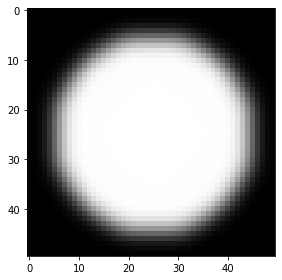

In [62]:
img = imread(os.path.join(DATA_DIR, 'example', 'test.png'))
# U = initialize((img.shape[0],img.shape[1]), r=15)
# dist_transformed_img = distance_transform(img, sigma=2)
curve_evolution(img)